In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 코드 실행결과의 동일성을 위해 무작위 시드를 설정합니다
manualSeed = 8592
# manualSeed = random.randint(1, 10000) # 만일 새로운 결과를 원한다면 주석을 없애면 됩니다
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

np.random.seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)
cudnn.benchmark = False
cudnn.deterministic = True

Random Seed:  8592


### pretrain

In [2]:
dataroot = "/content/drive/MyDrive/dataset_patch_220117/train"
#dataroot = "/content/drive/MyDrive/dataset_cyst" #cyst 데이터셋만
# dataroot = "/content/drive/MyDrive/dataset_meta" #meta 데이터셋만
# dataroot = "/content/drive/MyDrive/dataset_hema" #hema 데이터셋만
workers = 2 #데이터 불러올 때 사용할 쓰레드 개수
batch_size = 32
image_size = 64
nc = 3 #색 채널 개수 (RGB)
nz = 100 #벡터 원소개수
ngf = 64
ndf = 64
num_epochs = 300
lr = 0.00001 #2e-4=0.0002, 1e-4=0.001
beta1 = 0.5 #Adam optimizer 하이퍼파라미터 값. 논문처럼 0.5
ngpu = 1

In [3]:
#데이터셋 만들기
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size), #가운데 부분을 image_size로 자름
                               transforms.ToTensor(), #이미지 데이터를 tensor로 바꿈
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #정규화
                           ]))
# dataloader 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# GPU 사용여부
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [4]:
classes = dataset.classes
classes

['cyst', 'hema', 'meta']

##### check

In [5]:
print(dataset.__getitem__(13))

(tensor([[[-1.0000, -0.9686, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9686, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.8667, -0.8824, -0.9137,  ...,  0.9843,  0.9137,  0.8667],
         [-1.0000, -0.9765, -0.9843,  ...,  0.8667,  0.8118,  0.7725],
         [-0.9765, -0.8745, -0.8431,  ...,  0.6471,  0.5686,  0.5294]],

        [[-1.0000, -0.9686, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9686, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.8667, -0.8824, -0.9137,  ...,  0.9843,  0.9137,  0.8667],
         [-1.0000, -0.9765, -0.9843,  ...,  0.8667,  0.8118,  0.7725],
         [-0.9765, -0.8745, -0.8431,  ...,  0.6471,  0.5686,  0.5294]],

        [[-1.0000, -0.9686, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-0.9765, -1.0000, -1.0000,  ..., -

In [ ]:
len(dataset)

681

In [ ]:
# seed값 확인
dataiter = iter(dataloader)
images, labels = next(dataiter)
print(labels)

tensor([0, 0, 2, 0, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 0])


In [ ]:
for batch_size, (inputs, labels) in enumerate(dataloader):
  print(inputs.size())
  print("{} batch \n inputs[0][0][0][0] : {} \n labels: {}".format(batch_size, inputs[0][0][0][0], labels))
  #print("{} batch \n inputs[0][0][0][0]".format(batch_size))
  if batch_size ==2:
    break

torch.Size([16, 3, 64, 64])
0 batch 
 inputs[0][0][0][0] : -0.6078431606292725 
 labels: tensor([0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 2])
torch.Size([16, 3, 64, 64])
1 batch 
 inputs[0][0][0][0] : 0.5137255191802979 
 labels: tensor([0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0])
torch.Size([16, 3, 64, 64])
2 batch 
 inputs[0][0][0][0] : 0.7803921699523926 
 labels: tensor([0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1])


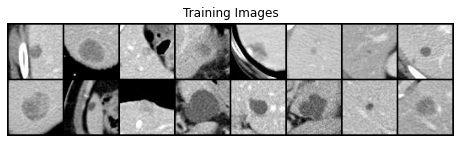

In [ ]:
# 화면에 이미지 몇 개 띄우기
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],padding=2, normalize=True).cpu(),(1,2,0)))
#nrow=3, 

##### 설정

In [6]:
def weights_init(m):
    # print('m : ',m)
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # print('before Conv m.weight.data. : ', m.weight.data)
        nn.init.normal_(m.weight.data, 0.0, 0.02) # 가중치를 평균 0, 편차 0.02로 초기화
        # print('after Conv m.weight.data. : ', m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # 가중치를 평균 1, 편차 0.02로 초기화
        # print('BatchNorm m.weight.data. : ', m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [7]:
#nn.ConvTranspose2d(input의 채널수, output의 채널 수, kernel size, stride, padding)

In [8]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

In [9]:
netG = Generator(ngpu).to(device)

# multi-gpu 필요하면 설정
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [12]:
# BCELoss 함수의 인스턴스 생성
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성 (Generator의 학습 과정 추적 위해)
fixed_noise = torch.randn(1, nz, 1, 1, device=device) # 64

# 학습에 사용되는 참/거짓의 라벨
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam optimizer를 생성
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [13]:
import torchvision
from torchvision.utils import save_image
transform = transforms.Grayscale()

In [16]:
! mkdir -p test/hema
! mkdir -p test/meta 
! mkdir -p test/cyst

In [14]:
n1 = 1
n2 = 1
n3 = 1

# img_list = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch (진짜 데이터들로 학습)
        netD.zero_grad()
        # Format batch (배치사이즈, 사용할 디바이스에 맞게 조정)
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D (진짜 데이터들로 이루어진 배치를 D에 통과)
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch(손실값 구함)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass (역전파 과정에서 변화도 계산)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch (가짜 데이터들로 학습)
        # Generate batch of latent vectors (벡터 생성)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G (G로 가짜 이미지 생성)
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D (D로 판별)
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch (D 손실값 계산)
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients(역전파로 변화도 계산 후 앞의 변화도에 더하기)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches (가짜 이미지, 진짜 이미지 손실값 모두 더함)
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z))) (G 신경망 업데이트)
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost (생성자 손실값 구하기 위해 진짜 라벨 이용)
        # Since we just updated D, perform another forward pass of all-fake batch through D (D가 방금 업데이트 됐기 때문에 다시 D에 가짜 데이터 통과)
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output (G 손실값 구하기)
        errG = criterion(output, label)
        # Calculate gradients for G (G 변화도 계산)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # 훈련상태 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]tLoss_D: %.4f tLoss_G: %.4f tD(x): %.4f tD(G(z)): %.4f / %.4f'
                % (epoch+1, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # 그래프 위해 손실값 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        # fixed_noise 통과시킨 G의 출력값 저장
        # if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, nrow=1, normalize=True))

        # 이미지 저장
        # if epoch == (num_epochs-1):
        #     for j in range(len(data[1])):
        #         if data[1][j] == 0:
        #             save_image(fake[j],'/content/dcgan_Result_b8_e300_lr0002_1205/cyst/DCGAN_cyst_%s.jpg' %(n1),'JPEG')
        #             n1 += 1
        #         if data[1][j] == 1:
        #             save_image(fake[j],'/content/dcgan_Result_b8_e300_lr0002_1205/hema/DCGAN_hema_%s.jpg' %(n2),'JPEG')
        #             n2 += 1
        #         if data[1][j] == 2:
        #             save_image(fake[j],'/content/dcgan_Result_b8_e300_lr0002_1205/meta/DCGAN_meta_%s.jpg' %(n3),'JPEG')
        #             n3 += 1
        if epoch == (num_epochs-1):
            for j in range(len(data[1])):
                if data[1][j] == 0:
                    save_image(fake[j],'/content/test/cyst/DCGAN_cyst_%s.jpg' %(n1),'JPEG')
                    n1 += 1
                if data[1][j] == 1:
                    save_image(fake[j],'/content/test/hema/DCGAN_hema_%s.jpg' %(n2),'JPEG')
                    n2 += 1
                if data[1][j] == 2:
                    save_image(fake[j],'/content/test/meta/DCGAN_meta_%s.jpg' %(n3),'JPEG')
                    n3 += 1

        img_list2.append(fake)
        iters += 1

Starting Training Loop...
[1/300][0/22]tLoss_D: 1.7471 tLoss_G: 0.7048 tD(x): 0.5707 tD(G(z)): 0.6125 / 0.5332
[2/300][0/22]tLoss_D: 0.6586 tLoss_G: 1.6602 tD(x): 0.7762 tD(G(z)): 0.2918 / 0.2524
[3/300][0/22]tLoss_D: 0.4962 tLoss_G: 1.7982 tD(x): 0.8740 tD(G(z)): 0.2757 / 0.2247
[4/300][0/22]tLoss_D: 0.4344 tLoss_G: 1.9379 tD(x): 0.8838 tD(G(z)): 0.2428 / 0.1978
[5/300][0/22]tLoss_D: 0.3839 tLoss_G: 2.1219 tD(x): 0.8900 tD(G(z)): 0.1920 / 0.1632
[6/300][0/22]tLoss_D: 0.3469 tLoss_G: 2.1732 tD(x): 0.9066 tD(G(z)): 0.1778 / 0.1449
[7/300][0/22]tLoss_D: 0.3373 tLoss_G: 2.4765 tD(x): 0.8736 tD(G(z)): 0.1418 / 0.1181
[8/300][0/22]tLoss_D: 0.2168 tLoss_G: 2.6139 tD(x): 0.9434 tD(G(z)): 0.1348 / 0.1024
[9/300][0/22]tLoss_D: 0.2289 tLoss_G: 2.7462 tD(x): 0.9125 tD(G(z)): 0.1121 / 0.0902
[10/300][0/22]tLoss_D: 0.1988 tLoss_G: 2.7663 tD(x): 0.9359 tD(G(z)): 0.1148 / 0.0885
[11/300][0/22]tLoss_D: 0.1800 tLoss_G: 2.8659 tD(x): 0.9411 tD(G(z)): 0.1014 / 0.0768
[12/300][0/22]tLoss_D: 0.2139 tLoss_G

In [ ]:
# 가중치 조절 전
print(
'epoch', num_epochs,
'model_G_state_dict', netG.state_dict(),
'model_D_state_dict', netD.state_dict()
)

In [ ]:
print(
'optimizer_G_state_dict', optimizerG.state_dict(),
'optimizer_D_state_dict', optimizerD.state_dict()
)

In [ ]:
# state dict 저장
torch.save({
    'epoch': num_epochs,
    'model_G_state_dict': netG.state_dict(),
    'model_D_state_dict': netD.state_dict(),
    'optimizer_G_state_dict': optimizerG.state_dict(),
    'optimizer_D_state_dict': optimizerD.state_dict()
}, 'model_weights.pth')

### fine tuning

In [2]:
# state dict 불러오기
path = '/content/drive/MyDrive/model_weights.pth'
# path = '/content/model_weights_e150b16r0001.pth'
weightsave = torch.load(path)

In [3]:
weightsave.keys()

dict_keys(['epoch', 'model_G_state_dict', 'model_D_state_dict', 'optimizer_G_state_dict', 'optimizer_D_state_dict'])

In [4]:
# dataroot = "/content/drive/MyDrive/dataset_patch_220117/train"
#dataroot = "/content/drive/MyDrive/dataset_cyst" #cyst 데이터셋만
# dataroot = "/content/drive/MyDrive/dataset_meta" #meta 데이터셋만
dataroot = "/content/drive/MyDrive/dataset_hema" #hema 데이터셋만
workers = 2 #데이터 불러올 때 사용할 쓰레드 개수
batch_size = 16
image_size = 64
nc = 3 #색 채널 개수 (RGB)
nz = 100 #벡터 원소개수
ngf = 64
ndf = 64
num_epochs = 100
lr = 0.00001 #2e-4=0.0002, 1e-4=0.001
beta1 = 0.5 #Adam optimizer 하이퍼파라미터 값. 논문처럼 0.5
ngpu = 1

In [5]:
#데이터셋 만들기
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size), #가운데 부분을 image_size로 자름
                               transforms.ToTensor(), #이미지 데이터를 tensor로 바꿈
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), #정규화
                           ]))
# dataloader 정의
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# GPU 사용여부
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

classes = dataset.classes
classes

['hema']

In [6]:
def weights_init(m):
    # print('m : ',m)
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # print('before Conv m.weight.data. : ', m.weight.data)
        nn.init.normal_(m.weight.data, 0.0, 0.02) # 가중치를 평균 0, 편차 0.02로 초기화
        # print('after Conv m.weight.data. : ', m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # 가중치를 평균 1, 편차 0.02로 초기화
        # print('BatchNorm m.weight.data. : ', m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        return self.main(input)

In [8]:
netG = Generator(ngpu).to(device)

# multi-gpu 필요하면 설정
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [9]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)

In [10]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
# BCELoss 함수의 인스턴스 생성
criterion = nn.BCELoss()

# 생성자의 학습상태를 확인할 잠재 공간 벡터를 생성 (Generator의 학습 과정 추적 위해)
fixed_noise = torch.randn(1, nz, 1, 1, device=device) # 64

# 학습에 사용되는 참/거짓의 라벨
real_label = 1.
fake_label = 0.

# G와 D에서 사용할 Adam optimizer를 생성
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [12]:
import torchvision
from torchvision.utils import save_image
transform = transforms.Grayscale()

In [13]:
netG.load_state_dict(weightsave['model_G_state_dict'])
# netD.load_state_dict(weightsave['model_D_state_dict'])

optimizerG.load_state_dict(weightsave['optimizer_G_state_dict'])
# optimizerD.load_state_dict(weightsave['optimizer_D_state_dict'])

In [14]:

# G와 D에서 사용할 Adam optimizer 초기화
# optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
# optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
! mkdir -p test2/hema

In [16]:
n4 = 1


# img_list = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch (진짜 데이터들로 학습)
        netD.zero_grad()
        # Format batch (배치사이즈, 사용할 디바이스에 맞게 조정)
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D (진짜 데이터들로 이루어진 배치를 D에 통과)
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch(손실값 구함)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass (역전파 과정에서 변화도 계산)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch (가짜 데이터들로 학습)
        # Generate batch of latent vectors (벡터 생성)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G (G로 가짜 이미지 생성)
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D (D로 판별)
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch (D 손실값 계산)
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients(역전파로 변화도 계산 후 앞의 변화도에 더하기)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches (가짜 이미지, 진짜 이미지 손실값 모두 더함)
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z))) (G 신경망 업데이트)
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost (생성자 손실값 구하기 위해 진짜 라벨 이용)
        # Since we just updated D, perform another forward pass of all-fake batch through D (D가 방금 업데이트 됐기 때문에 다시 D에 가짜 데이터 통과)
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output (G 손실값 구하기)
        errG = criterion(output, label)
        # Calculate gradients for G (G 변화도 계산)
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # 훈련상태 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]tLoss_D: %.4f tLoss_G: %.4f tD(x): %.4f tD(G(z)): %.4f / %.4f'
                % (epoch+1, num_epochs, i, len(dataloader),
                    errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        # 그래프 위해 손실값 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    
        # fixed_noise 통과시킨 G의 출력값 저장
        # if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #     with torch.no_grad():
        #         fake = netG(fixed_noise).detach().cpu()
        #     img_list.append(vutils.make_grid(fake, padding=2, nrow=1, normalize=True))

        # 이미지 저장
        # if epoch == (num_epochs-1):
        #     for j in range(len(data[1])):
        #         if data[1][j] == 0:
        #             save_image(fake[j],'/content/dcgan_Result_b8_e300_lr0002_1205/cyst/DCGAN_cyst_%s.jpg' %(n1),'JPEG')
        #             n1 += 1
        #         if data[1][j] == 1:
        #             save_image(fake[j],'/content/dcgan_Result_b8_e300_lr0002_1205/hema/DCGAN_hema_%s.jpg' %(n2),'JPEG')
        #             n2 += 1
        #         if data[1][j] == 2:
        #             save_image(fake[j],'/content/dcgan_Result_b8_e300_lr0002_1205/meta/DCGAN_meta_%s.jpg' %(n3),'JPEG')
        #             n3 += 1
        
        
        if epoch == (num_epochs-1):
            for j in range(len(data[1])):
                save_image(fake[j],'/content/test2/hema/DCGAN_hema_%s.jpg' %(n4),'JPEG')
                n4 += 1

        img_list2.append(fake)
        iters += 1

Starting Training Loop...
[1/100][0/5]tLoss_D: 1.6202 tLoss_G: 0.6119 tD(x): 0.6798 tD(G(z)): 0.6537 / 0.5546
[2/100][0/5]tLoss_D: 2.2764 tLoss_G: 0.4901 tD(x): 0.6217 tD(G(z)): 0.7280 / 0.6842
[3/100][0/5]tLoss_D: 2.1900 tLoss_G: 0.3624 tD(x): 0.5681 tD(G(z)): 0.7715 / 0.7071
[4/100][0/5]tLoss_D: 2.6317 tLoss_G: 0.3548 tD(x): 0.4669 tD(G(z)): 0.7750 / 0.7230
[5/100][0/5]tLoss_D: 2.2957 tLoss_G: 0.6549 tD(x): 0.4166 tD(G(z)): 0.6539 / 0.5980
[6/100][0/5]tLoss_D: 2.5236 tLoss_G: 0.4418 tD(x): 0.4623 tD(G(z)): 0.7385 / 0.6752
[7/100][0/5]tLoss_D: 2.5411 tLoss_G: 0.4907 tD(x): 0.4214 tD(G(z)): 0.7075 / 0.6565
[8/100][0/5]tLoss_D: 2.3529 tLoss_G: 0.5035 tD(x): 0.4692 tD(G(z)): 0.7115 / 0.6575
[9/100][0/5]tLoss_D: 2.1624 tLoss_G: 0.5122 tD(x): 0.4957 tD(G(z)): 0.6974 / 0.6378
[10/100][0/5]tLoss_D: 2.0861 tLoss_G: 0.5070 tD(x): 0.5030 tD(G(z)): 0.6871 / 0.6226
[11/100][0/5]tLoss_D: 2.4797 tLoss_G: 0.3597 tD(x): 0.5260 tD(G(z)): 0.7958 / 0.7236
[12/100][0/5]tLoss_D: 2.2340 tLoss_G: 0.4303 tD(

In [ ]:
# 가중치 조절 후
print(
'epoch', num_epochs,
'model_G_state_dict', netG.state_dict(),
'model_D_state_dict', netD.state_dict()
)

In [ ]:
print(
'optimizer_G_state_dict', optimizerG.state_dict(),
'optimizer_D_state_dict', optimizerD.state_dict()
)

In [ ]:
for j in range(len(data[1])):
    # if data[1][j] == 0:
    #     save_image(fake[j],'/content/test2/cyst/DCGAN_cyst_%s.jpg' %(n1),'JPEG')
    #     n1 += 1
    # if data[1][j] == 1:
        save_image(fake[j],'/content/test2/hema/DCGAN_hema_%s.jpg' %(n2),'JPEG')
        n2 += 1
    # if data[1][j] == 2:
    #     save_image(fake[j],'/content/test2/meta/DCGAN_meta_%s.jpg' %(n3),'JPEG')
    #     n3 += 1

In [ ]:
len(img_list2)

2580

In [24]:
torch.save({
    'epoch': num_epochs,
    'model_G_state_dict': netG.state_dict(),
    'model_D_state_dict': netD.state_dict(),
    'optimizer_G_state_dict': optimizerG.state_dict(),
    'optimizer_D_state_dict': optimizerD.state_dict()
}, 'model_weights_e150b16r0001.pth')

In [ ]:
# torch.load('model_weights.pth')

In [ ]:
print(
'epoch', num_epochs,
'model_G_state_dict', netG.state_dict(),
'model_D_state_dict', netD.state_dict(),
'optimizer_G_state_dict', optimizerG.state_dict(),
'optimizer_D_state_dict', optimizerD.state_dict()
)

epoch 30


In [ ]:
netG

In [ ]:
netG.apply(weights_init)

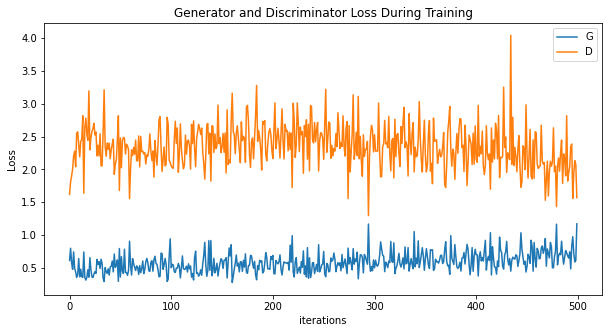

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
len(img_list2)

500

In [20]:
#dip
#생성된 이미지 확인
from torchvision.utils import save_image
transform = transforms.Grayscale()

save_image(img_list2[1], 'image_name1-1.png')
save_image(img_list2[2], 'image_name1-2.png')
save_image(img_list2[3], 'image_name1-3.png')
save_image(img_list2[4], 'image_name1-4.png')
save_image(img_list2[5], 'image_name1-5.png')
# save_image(img_list2[494], 'image_name1-6.png')
# save_image(img_list2[6500], 'image_name1-7.png')
# save_image(img_list2[6600], 'image_name1-8.png')
# save_image(img_list2[6700], 'image_name1-9.png')

In [ ]:
from google.colab import files
files.download('/content/dcgan_hema_Result_1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
real_batch = next(iter(dataloader))

# Plot the real images (진짜 이미지 화면 출력)

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))


# Plot the fake images from the last epoch (가짜 이미지 화면 출력)

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list2[-1],(1,2,0)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
# finetuning

In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/content/drive/MyDrive/dataset_patch_220117/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.9518 Acc: 0.6065
val Loss: 1.1569 Acc: 0.3974

Epoch 1/14
----------
train Loss: 0.8504 Acc: 0.6300
val Loss: 1.1165 Acc: 0.4272

Epoch 2/14
----------
train Loss: 0.8578 Acc: 0.6300
val Loss: 0.8855 Acc: 0.5762

Epoch 3/14
----------
train Loss: 0.9123 Acc: 0.6153
val Loss: 1.1571 Acc: 0.4371

Epoch 4/14
----------
train Loss: 0.8962 Acc: 0.6050
val Loss: 0.9371 Acc: 0.5397

Epoch 5/14
----------
train Loss: 0.8603 Acc: 0.6226
val Loss: 1.1402 Acc: 0.4735

Epoch 6/14
----------
train Loss: 0.8435 Acc: 0.6505
val Loss: 1.1332 Acc: 0.4967

Epoch 7/14
----------
train Loss: 0.8263 Acc: 0.6490
val Loss: 0.9322 Acc: 0.5596

Epoch 8/14
----------
train Loss: 0.9016 Acc: 0.5991
val Loss: 0.9714 Acc: 0.5596

Epoch 9/14
----------
train Loss: 0.8606 Acc: 0.6432
val Loss: 0.9397 Acc: 0.5728

Epoch 10/14
----------
train Loss: 0.8650 Acc: 0.6432
val Loss: 0.9980 Acc: 0.5397

Epoch 11/14
----------
train Loss: 0.8332 Acc: 0.6520
val Loss: 0.8870 Acc: 0.5762

Ep

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/14
----------
train Loss: 1.8952 Acc: 0.5051
val Loss: 8.1659 Acc: 0.3808

Epoch 1/14
----------
train Loss: 1.4919 Acc: 0.5433
val Loss: 1.5560 Acc: 0.3808

Epoch 2/14
----------
train Loss: 1.3129 Acc: 0.5698
val Loss: 1.5036 Acc: 0.4437

Epoch 3/14
----------
train Loss: 1.0377 Acc: 0.5800
val Loss: 1.6141 Acc: 0.4007

Epoch 4/14
----------
train Loss: 1.1038 Acc: 0.5727
val Loss: 1.2773 Acc: 0.3808

Epoch 5/14
----------
train Loss: 0.9823 Acc: 0.5962
val Loss: 1.1486 Acc: 0.3874

Epoch 6/14
----------
train Loss: 0.9462 Acc: 0.6021
val Loss: 1.0412 Acc: 0.4106

Epoch 7/14
----------
train Loss: 0.9401 Acc: 0.6035
val Loss: 1.1277 Acc: 0.3841

Epoch 8/14
----------
train Loss: 0.9244 Acc: 0.6021
val Loss: 1.3715 Acc: 0.3742

Epoch 9/14
----------
train Loss: 0.9356 Acc: 0.5991
val Loss: 1.1657 Acc: 0.4040

Epoch 10/14
----------
train Loss: 0.9426 Acc: 0.6138
val Loss: 1.1667 Acc: 0.4007

Epoch 11/14
----------
train Loss: 0.9059 Acc: 0.6167
val Loss: 1.0964 Acc: 0.3808

Ep

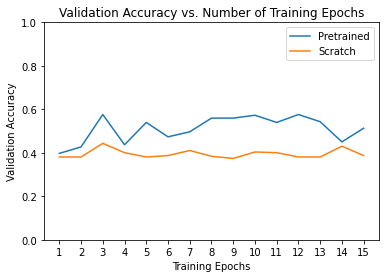

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()